In [1]:
import HARK.ConsumptionSaving.ConsPortfolioModel as cpm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
import sys

sys.path.append('.')

import hark_portfolio_agents as hpa

In [3]:
sys.path.append('../PNL/py')

import util as UTIL
import pnl as pnl

## How to use this code


### Initialize the agents to start

This is to set up the agent parameters and quantities used in the simulation.

In [11]:
## List of tuples: 
##  ( parameters, (i.e. coefficient of relative risk aversion CRRA)
##    number of agents represented,
##    ( initial risky percent, $$$ in risky asset, $$$ in riskless asset)
agent_classes = [
    ({'CRRA': 5.0}, 100, 10), # Normal consumers
    ({'CRRA': 6.0}, 50,  10),  # More risk-averse consumers
    ({'CRRA': 4.0}, 50,  10)  #  Less risk-averse consumers
]


### parameters shared by all agents
ap = {
    'AdjustPrb' : 1.0, # probabability of rebalancing during simulation
    'aNrmInitStd' : 0.0,
    'pLvlInitMean' : 1.0, # initial distribution of permanent income
    'pLvlInitStd' : 0.0
}

In [12]:
agents = hpa.create_agents(agent_classes, ap)

In [13]:
agents[0].state_now["mNrmNow"]

array([21758.4000674 , 21758.4000674 , 22575.01392839, 24453.49999542,
       20838.78035494, 21758.4000674 , 24453.49999542, 21758.4000674 ,
       20838.78035494, 23421.90672017, 23421.90672017, 22575.01392839,
       20838.78035494, 22575.01392839, 20838.78035494, 23421.90672017,
       22575.01392839, 24453.49999542, 26414.26059461, 23421.90672017,
       26414.26059461, 24453.49999542, 23421.90672017, 20838.78035494,
       26414.26059461, 19258.98586554, 19258.98586554, 19258.98586554,
       24453.49999542, 22575.01392839, 19258.98586554, 24453.49999542,
       19258.98586554, 21758.4000674 , 21758.4000674 , 23421.90672017,
       23421.90672017, 23421.90672017, 20838.78035494, 21758.4000674 ,
       24453.49999542, 26414.26059461, 20838.78035494, 21758.4000674 ,
       23421.90672017, 21758.4000674 , 19258.98586554, 23421.90672017,
       22575.01392839, 20838.78035494, 21758.4000674 , 26414.26059461,
       21758.4000674 , 24453.49999542, 19258.98586554, 19258.98586554,
      

In [14]:
agents[0].state_now["pLvlNow"]

array([2.83445475, 2.83445475, 2.73191849, 2.52204748, 2.95954583,
       2.83445475, 2.52204748, 2.83445475, 2.95954583, 2.63313315,
       2.63313315, 2.73191849, 2.95954583, 2.73191849, 2.95954583,
       2.63313315, 2.73191849, 2.52204748, 2.33482594, 2.63313315,
       2.33482594, 2.52204748, 2.63313315, 2.95954583, 2.33482594,
       3.20232689, 3.20232689, 3.20232689, 2.52204748, 2.73191849,
       3.20232689, 2.52204748, 3.20232689, 2.83445475, 2.83445475,
       2.63313315, 2.63313315, 2.63313315, 2.95954583, 2.83445475,
       2.52204748, 2.33482594, 2.95954583, 2.83445475, 2.63313315,
       2.83445475, 3.20232689, 2.63313315, 2.73191849, 2.95954583,
       2.83445475, 2.33482594, 2.83445475, 2.52204748, 3.20232689,
       3.20232689, 2.73191849, 2.83445475, 2.73191849, 2.33482594,
       2.63313315, 2.52204748, 2.73191849, 2.83445475, 2.33482594,
       2.83445475, 2.83445475, 2.63313315, 2.83445475, 2.52204748,
       2.52204748, 2.63313315, 2.33482594, 2.73191849, 2.33482

#### Test agent

This is a test agent used to test and demonstrate the functions below.

In [ ]:
# test agent
agent = cpm.PortfolioConsumerType(
    AgentCount = 3,
    **ap
)
agent.solve()
agent.T_sim = 100
agent.track_vars += ['pLvlNow','mNrmNow','ShareNow','RiskyNow']
agent.initializeSim()
agent.simulate()

In [ ]:
### This is not working for some reason!

plt.plot(agent.history['mNrmNow'] * agent.history['pLvlNow'])

In [ ]:
plt.plot(agent.history['RiskyNow'])

The normalize market assets of each agent at the current (final) stage of the simulation.

The function from normalized market assets to the proportion of assets allocated to the risky share.

### Synthetic price data

In the future, get this from the LiquidityModel.

For now, just use any array of prices with noise and drift.

In [19]:
## This is a dummy method that the ABM group
## needs to write to connect to the NetLogo
## model.

def run_market(buy_sell, asset_price):
    config = UTIL.read_config(config_file="../PNL/macroliquidity.ini")
    pnl.run_NLsims(
        config,
        # just simply rounding here to get number of shares from dollar buy/sell amounts
        broker_buy_limit = round(buy_sell[0] / asset_price),
        broker_sell_limit = round(buy_sell[1] / asset_price))
    
def get_orders():
    # use run_market() first to create logs
    orders = pd.read_csv("../PNL/out/logs/LMallorders_90_5.csv", delimiter='\t')
    return orders

### Agents estimate return rate and volatility from historical data

The agents look at the most recent historical price data to form their expectations of the future.

This is a very simplified version of what could later be better specified in line with _adaptive expectations_:

https://en.wikipedia.org/wiki/Adaptive_expectations

### Demand function for the intermittent demand problem

In the intermittent demand problem, consumers take their current state and determine risky porfolio share of their assets to invest.

The agent responds to the price history by:
 - updating their current assets
 - updating their expectations of the risky asset
 - returning their risky share allocation.

Other aspects of the problem are fixed for now.

### Putting it all together

Each agent knows their old risky allocation, old risk free allocation, and the prices of the last quarter.

They computer their new market assets and then their new demand.

In [20]:
# STEP 1. Initialize the agents. (and the market?)

## List of tuples: 
##  ( parameters, (i.e. coefficient of relative risk aversion CRRA)
##    number of agents represented,
##    initial assets
agent_classes = [
    ({'CRRA': 5.0}, 100, 10), # Normal consumers
    ({'CRRA': 6.0}, 50,  10),  # More risk-averse consumers
    ({'CRRA': 4.0}, 50,  10)  #  Less risk-averse consumers
]


### parameters shared by all agents
ap = {
    'aNrmInitStd' : 0.0,
    'pLvlInitMean' : 1.0, # initial distribution of permanent income
    'pLvlInitStd' : 0.0
}


agents = hpa.create_agents(agent_classes, ap)

In [21]:
# STEP 2. Create starting demand for the market.
#         Burn in the new prices.

# The initial demands for each agent
# hpa.init_prices is used to set the agent's starting
# beliefs about the price process.
init_demands = hpa.demands(agents, hpa.init_prices)

buy_sell = hpa.aggregate_buy_and_sell(
    hpa.no_demand(agents), # zero allocated to risky asset
    init_demands
)


Getting risky asset demand for all agents
computing aggregate buy/sell orders


Initial Buy/Sell: (69354.0650814572, 0)
{'RiskyAvg': 0.8070698855709107, 'RiskyStd': 85.4947533263044}


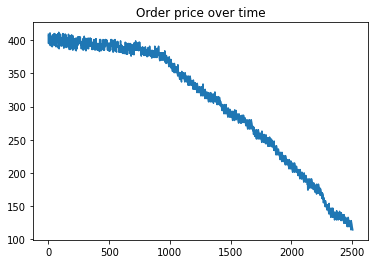

In [22]:
# STEP 3: Create the starting asset price. This will be used
#         to translate $$$ values to asset quantities
#         and adjust each period.

asset_price = 100

print(f"Initial Buy/Sell: {buy_sell}")

## TODO: ABM Group reimplement the run_market method
orders = get_orders()
print(hpa.risky_expectations(orders))
    
plt.plot(orders['OrderPrice'])
plt.title("Order price over time")
plt.show()


old_demands = init_demands

Asset price: 100
simulating macro agents
{'RiskyAvg': 0.8070698855709107, 'RiskyStd': 85.4947533263044}
Getting risky asset demand for all agents
computing aggregate buy/sell orders
Round 0 Buy/Sell: (0, 0.0)
{'RiskyAvg': 0.8070698855709107, 'RiskyStd': 85.4947533263044}


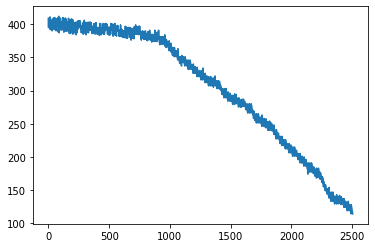

Asset price: 83.35946989608803
simulating macro agents
{'RiskyAvg': 0.8070698855709107, 'RiskyStd': 85.4947533263044}
Getting risky asset demand for all agents
computing aggregate buy/sell orders
Round 1 Buy/Sell: (0, 0.0)
{'RiskyAvg': 0.8070698855709107, 'RiskyStd': 85.4947533263044}


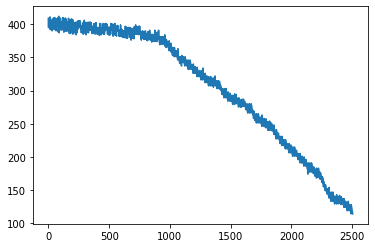

Asset price: 69.48801221356806
simulating macro agents
{'RiskyAvg': 0.8070698855709107, 'RiskyStd': 85.4947533263044}
Getting risky asset demand for all agents
computing aggregate buy/sell orders
Round 2 Buy/Sell: (0, 0.0)
{'RiskyAvg': 0.8070698855709107, 'RiskyStd': 85.4947533263044}


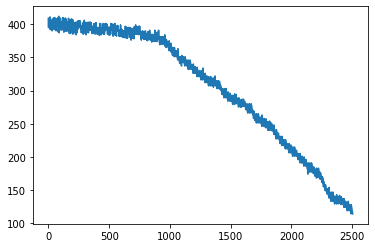

Asset price: 57.92483862255923
simulating macro agents
{'RiskyAvg': 0.8070698855709107, 'RiskyStd': 85.4947533263044}
Getting risky asset demand for all agents
computing aggregate buy/sell orders
Round 3 Buy/Sell: (0, 0.0)
{'RiskyAvg': 0.8070698855709107, 'RiskyStd': 85.4947533263044}


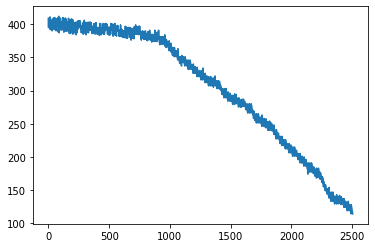

Asset price: 48.28583841392983
simulating macro agents
{'RiskyAvg': 0.8070698855709107, 'RiskyStd': 85.4947533263044}
Getting risky asset demand for all agents
computing aggregate buy/sell orders
Round 4 Buy/Sell: (0, 0.0)
{'RiskyAvg': 0.8070698855709107, 'RiskyStd': 85.4947533263044}


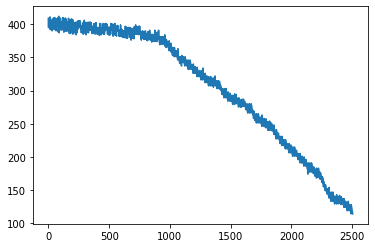

Asset price: 40.250818936733545
simulating macro agents
{'RiskyAvg': 0.8070698855709107, 'RiskyStd': 85.4947533263044}
Getting risky asset demand for all agents
computing aggregate buy/sell orders
Round 5 Buy/Sell: (0, 0.0)
{'RiskyAvg': 0.8070698855709107, 'RiskyStd': 85.4947533263044}


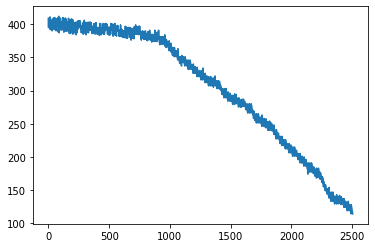

Asset price: 33.552869294495295
simulating macro agents
{'RiskyAvg': 0.8070698855709107, 'RiskyStd': 85.4947533263044}
Getting risky asset demand for all agents
computing aggregate buy/sell orders
Round 6 Buy/Sell: (0, 0.0)
{'RiskyAvg': 0.8070698855709107, 'RiskyStd': 85.4947533263044}


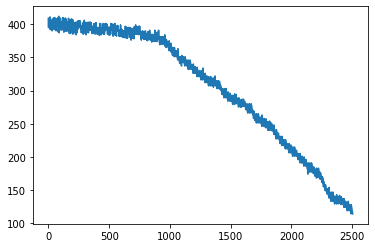

Asset price: 27.969493978818566
simulating macro agents
{'RiskyAvg': 0.8070698855709107, 'RiskyStd': 85.4947533263044}
Getting risky asset demand for all agents
computing aggregate buy/sell orders
Round 7 Buy/Sell: (0, 0.0)
{'RiskyAvg': 0.8070698855709107, 'RiskyStd': 85.4947533263044}


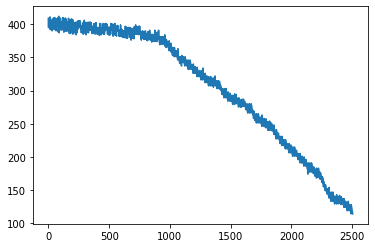

Asset price: 23.315221913361416
simulating macro agents
{'RiskyAvg': 0.8070698855709107, 'RiskyStd': 85.4947533263044}
Getting risky asset demand for all agents
computing aggregate buy/sell orders
Round 8 Buy/Sell: (0, 0.0)
{'RiskyAvg': 0.8070698855709107, 'RiskyStd': 85.4947533263044}


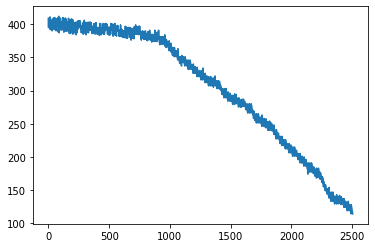

Asset price: 19.435445392074627
simulating macro agents
{'RiskyAvg': 0.8070698855709107, 'RiskyStd': 85.4947533263044}
Getting risky asset demand for all agents
computing aggregate buy/sell orders
Round 9 Buy/Sell: (0, 0.0)
{'RiskyAvg': 0.8070698855709107, 'RiskyStd': 85.4947533263044}


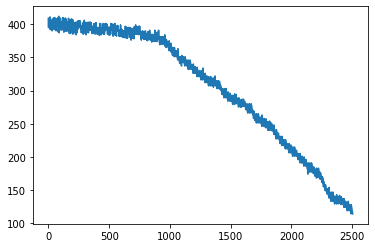

In [23]:
# STEP 4. Run simulation for N rebalances

N = 10

for i in range(N):
    
    print(f"Asset price: {asset_price}")

    # simulate one period on the macro side
    hpa.simulate(agents, 1)
    
    hpa.update_agents(agents, orders)
    print(hpa.risky_expectations(orders))
    new_demands = hpa.demands(agents, orders)
    
    buy_sell = hpa.aggregate_buy_and_sell(
        old_demands,
        new_demands
    )
    print(f"Round {i} Buy/Sell: {buy_sell}")

    #run_market(buy_sell, asset_price)
    orders = get_orders()
    print(hpa.risky_expectations(orders))
    
    plt.plot(orders['OrderPrice'])
    plt.show()
    
    old_demands = new_demands
    
    risky_return = hpa.risky_actual_return(orders)
    asset_price = asset_price * risky_return[0]

In [24]:
agents[0].history['RiskyNow'][:,0]

array([0.80706989])

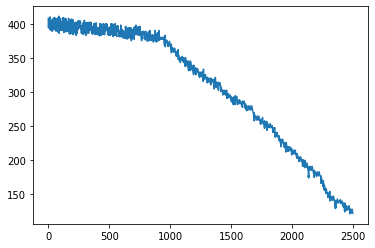

In [25]:
plt.plot(orders[orders['OrderQuantity'] > 0]['OrderPrice'])

In [26]:
orders['OrderQuantity'] > 0

0        True
1        True
2        True
3        True
4        True
        ...  
2502    False
2503    False
2504    False
2505    False
2506    False
Name: OrderQuantity, Length: 2507, dtype: bool

In [27]:
orders

,Tick,OrderID,OrderTime,OrderPrice,OrderTraderID,OrderQuantity,OrderBA,TraderWhoType
0,5003,3644,5002.0,409.0,8377,4.0,Sell,LiquiditySupplier
1,5005,3647,5004.0,395.0,5273,30.0,Buy,LiquidityDemander
2,5007,3649,5006.0,408.0,3490,5.0,Sell,MarketMakers
3,5007,3650,5006.0,400.0,3490,5.0,Buy,MarketMakers
4,5009,3651,5008.0,399.0,8225,35.0,Buy,LiquidityDemander
...,...,...,...,...,...,...,...,...
2502,6000,6886,5999.0,118.0,2138,0.0,Buy,MarketMakers
2503,6000,6887,5999.0,117.0,2138,0.0,Buy,MarketMakers
2504,6000,6888,5999.0,116.0,2138,0.0,Buy,MarketMakers
2505,6000,6889,5999.0,115.0,2138,0.0,Buy,MarketMakers


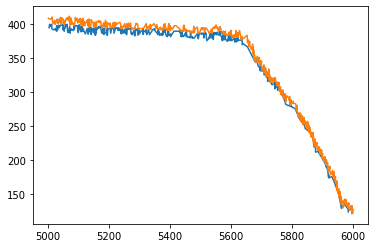

In [28]:
buys = orders[(orders['OrderBA'] == "Buy") & (orders['OrderQuantity'] > 0)]
sells = orders[(orders['OrderBA'] == "Sell") & (orders['OrderQuantity'] > 0)]


plt.plot(buys['Tick'], buys['OrderPrice'])
plt.plot(sells['Tick'], sells['OrderPrice'])


In [ ]:
sells

In [ ]:
(orders['OrderPrice'] * orders['OrderQuantity']).sum() / orders['OrderQuantity'].sum()

In [ ]:
hpa.risky_expectations(orders)

In [ ]:
orders[(orders['OrderBA'] == "Buy") & (orders['OrderQuantity'] > 0)]

In [ ]:
agents[0].solution[0].ShareFuncAdj(0)

In [ ]:
agents[0].state_now['mNrmNow']

In [ ]:
agents[0].state_now['pLvlNow']

In [ ]:
new_assets(agent, hpa.risky_share, prices)

In [ ]:
orders = pd.read_csv("../PNL/out/logs/LMallorders_90_5.csv", delimiter='\t')

In [ ]:
orders

In [ ]:
plt.plot(orders['OrderPrice'])

In [ ]:
orders['TraderWhoType'].unique()

In [ ]:
sales = orders[orders['TraderWhoType'] == 'LiqSellBkr']
avg_sale_price = sales['OrderQuantity'] * sales['OrderPrice'] / sales['OrderPrice'].sum()

In [ ]:
orders[orders['TraderWhoType'] == 'LiqBuyBkr']

In [ ]:
buys = orders[orders['TraderWhoType'] == 'LiqBuyBkr]
avg_buy_price = buys['OrderQuantity'] * buys['OrderPrice'] / buys['OrderPrice'].sum()

In [ ]:
agents[0].history['mNrmNow'][0][-1] - agents[0].history['mNrmNow'][0][0]

In [ ]:
agents[2].controls['ShareNow']

In [ ]:
orders

In [ ]:
orders[orders['OrderQuantity'] == 0].groupby('Tick').size()